In [1]:
using Revise
using MajoranaPropagation
using PauliPropagation

using Plots
using LaTeXStrings
using TimerOutputs
using ProgressMeter

Simulate the dynamics of the spinful Hubbard model on a 2D lattice of $N_x \times N_y$ spinful sites. The Hamiltonian is
$$\hat{H}=-t \sum_{\langle i,j\rangle, \sigma=\{\uparrow, \downarrow\}}\left(\hat{c}_{i, \sigma}^{\dagger} \hat{c}_{j, \sigma}+\hat{c}_{j, \sigma}^{\dagger} \hat{c}_{i, \sigma}\right)+U \sum_i \hat{n}_{i \uparrow} \hat{n}_{i \downarrow}$$

In [2]:
N_x = 4
N_y = 4
N_spinful_sites = N_x * N_y
t = 1.
U = 2.

n_layers = 12
dt = 0.07

0.07

Get 1D connectivity, and create the circtuit for implementing a single layer of first order Trotterization.

In [3]:
topo = rectangletopology(N_x, N_y)

circ_single = []
thetas_single = []

#up hoppings 
for (i, j) in topo
    push!(circ_single, FermionicGate(:hopup, [i, j]))
    push!(thetas_single, -t * dt)
end

#down hoppings 
for (i, j) in topo
    push!(circ_single, FermionicGate(:hopdn, [i, j]))
    push!(thetas_single, -t * dt)
end

#on-site repulsion 
for i = 1:N_spinful_sites
    push!(circ_single, FermionicGate(:nupndn, i))
    push!(thetas_single, U * dt)
end

#### Set the truncations
1. `min_abs_coeff`: PP coefficient truncation
2. `max_singles`: number of unpaired Majoranas, namely the number of indices $i$ where only one of $\gamma_i$, $\gamma'_i$ are non-zero

In [4]:
min_abs_coeff = 1.e-5
max_singles = 6

max_single_filter = create_max_single_filter(2 * N_spinful_sites)
custom_trunc = let max_single_filter=max_single_filter, max_singles = max_singles
    (mstr, coeff) -> (compute_max_single(mstr, 0, max_single_filter) > max_singles)
end

#11 (generic function with 1 method)

Set the inital state as the checkerboard state $\ket{\uparrow\downarrow\cdots\uparrow\downarrow}$

In [5]:
#initial state 
initial_state_label = "Checkerboard"

create_up_part_at = []
create_down_part_at = []

for j=1:N_spinful_sites 
    if j % 2 == 1
        push!(create_up_part_at, j)
    else 
        push!(create_down_part_at, j)
    end 
end

Backpropagate $n_{2,\uparrow}$, the up density on site 2

In [6]:
to = TimerOutput()

site_index = 3
obs = MajoranaSum(N_spinful_sites, :nupndn, site_index)

@show obs 

res = zeros(n_layers+1)
res[1] = overlap_with_fock_spinful(obs, create_up_part_at, create_down_part_at, 2 * N_spinful_sites)
length_res = zeros(n_layers+1)
length_res[1] = length(obs)

@showprogress for k=1:n_layers
    @timeit to "propagate" propagate!(circ_single, obs, thetas_single, min_abs_coeff=min_abs_coeff, customtruncfunc=custom_trunc)
    @timeit to "evaluate" res[k+1] = overlap_with_fock_spinful(obs, create_up_part_at, create_down_part_at, 2 * N_spinful_sites)
    length_res[k+1] = length(obs)
end 

to

obs = MajoranaSum with 4 term(s):(
    0.25 * 0000000000000000000000000000000000000000000000000000000000000000
    0.25 * 0000000011000000000000000000000000000000000000000000000000000000
    -0.25 * 0000000011110000000000000000000000000000000000000000000000000000
    0.25 * 0000000000110000000000000000000000000000000000000000000000000000)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


──────────────────────────────────────────────────────────────────────
                             Time                    Allocations      
                    ───────────────────────   ────────────────────────
 Tot / % measured:       14.9s /  90.6%           4.72GiB /  92.5%    

Section     ncalls     time    %tot     avg     alloc    %tot      avg
──────────────────────────────────────────────────────────────────────
propagate       12    13.3s   98.8%   1.11s   4.18GiB   95.8%   357MiB
evaluate        12    166ms    1.2%  13.8ms    187MiB    4.2%  15.6MiB
──────────────────────────────────────────────────────────────────────

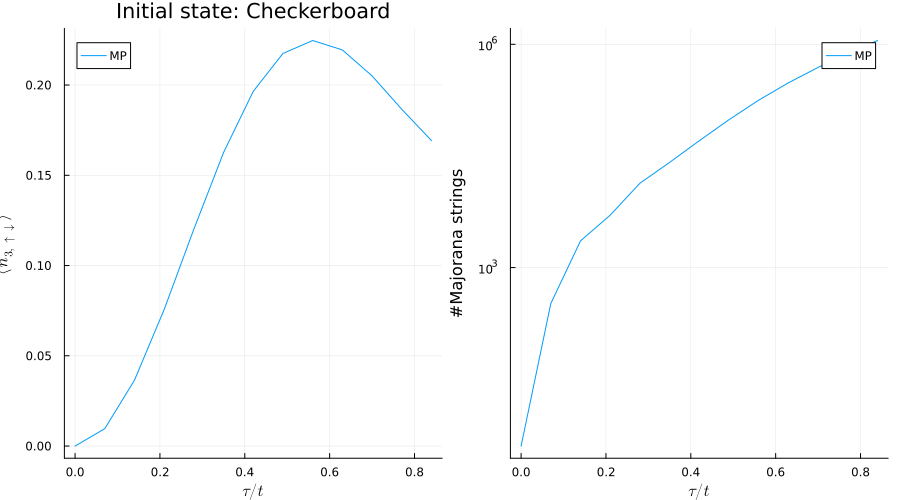

In [7]:
p_res = plot(dt*(0:n_layers)./ t, res, label="MP", xlabel=L"\tau/t", ylabel=L"\langle n_{%$site_index,\uparrow\downarrow}\rangle", title = "Initial state: " * initial_state_label)
p_length = plot(dt*(0:n_layers)./ t, length_res, label="MP", xlabel=L"\tau/t", ylabel="#Majorana strings", yscale=:log10)    

plot(p_res, p_length, layout=(1,2), size=(900,500))